In [2]:
import numpy as np
from matplotlib import pyplot as plt
from functools import partial
from ionoptics import geometry as geo
from ionoptics import beamline as bl
from ionoptics import bmad

In [121]:
# beamsize
##JULIC
### 1 sigma x = 6 mm
### 1 sigma y = 9 mm

##HBS LINAC
### diameter ~ 10 mm (6 sigma)
### 1 sigma = 1.5 mm

sigma_x = 2.7e-3

## quadrupole position evaluation

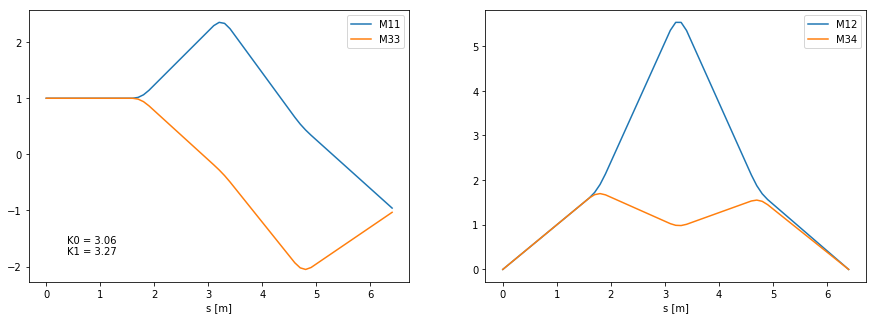

total length:  6.5


In [16]:
l = 1.6 # from object to 1st q
L = 0.3 # q thickness
d = 1.2 # dist. betw. q's

k0,k1 = bl.opt_trip(l,L,d,[2,3])

lengths = [l,L,d,L,d,L,l]
elements = [bl.drift,partial(bl.qdf, k=k0),bl.drift,partial(bl.qf, k=k1),bl.drift,partial(bl.qdf, k=k0),bl.drift]

axes = bl.plot_M_vs_s(elements,lengths,figsize = (15,5))

axes[0].text(0.1,0.1,'K0 = {:.2f}\nK1 = {:.2f}'.format(k0,k1),transform=axes[0].transAxes)

#PATH_TO_DATA = '../../Multiplexer/Plots/'
#FILENAME = 'QT_eval-{}_{}_{}'.format(l,d,L)
#plt.savefig(PATH_TO_DATA + FILENAME, format = 'png', dpi=900)

plt.show()

print('total length: ', round(2*l+2*d+3*L,2))

### bmad cross check

xmax @  start: 0.009547864902199688
xmax @  end: 0.010579434224558669
ymax @  start: 0.015542137307149644
ymax @  end: 0.015812858562487656


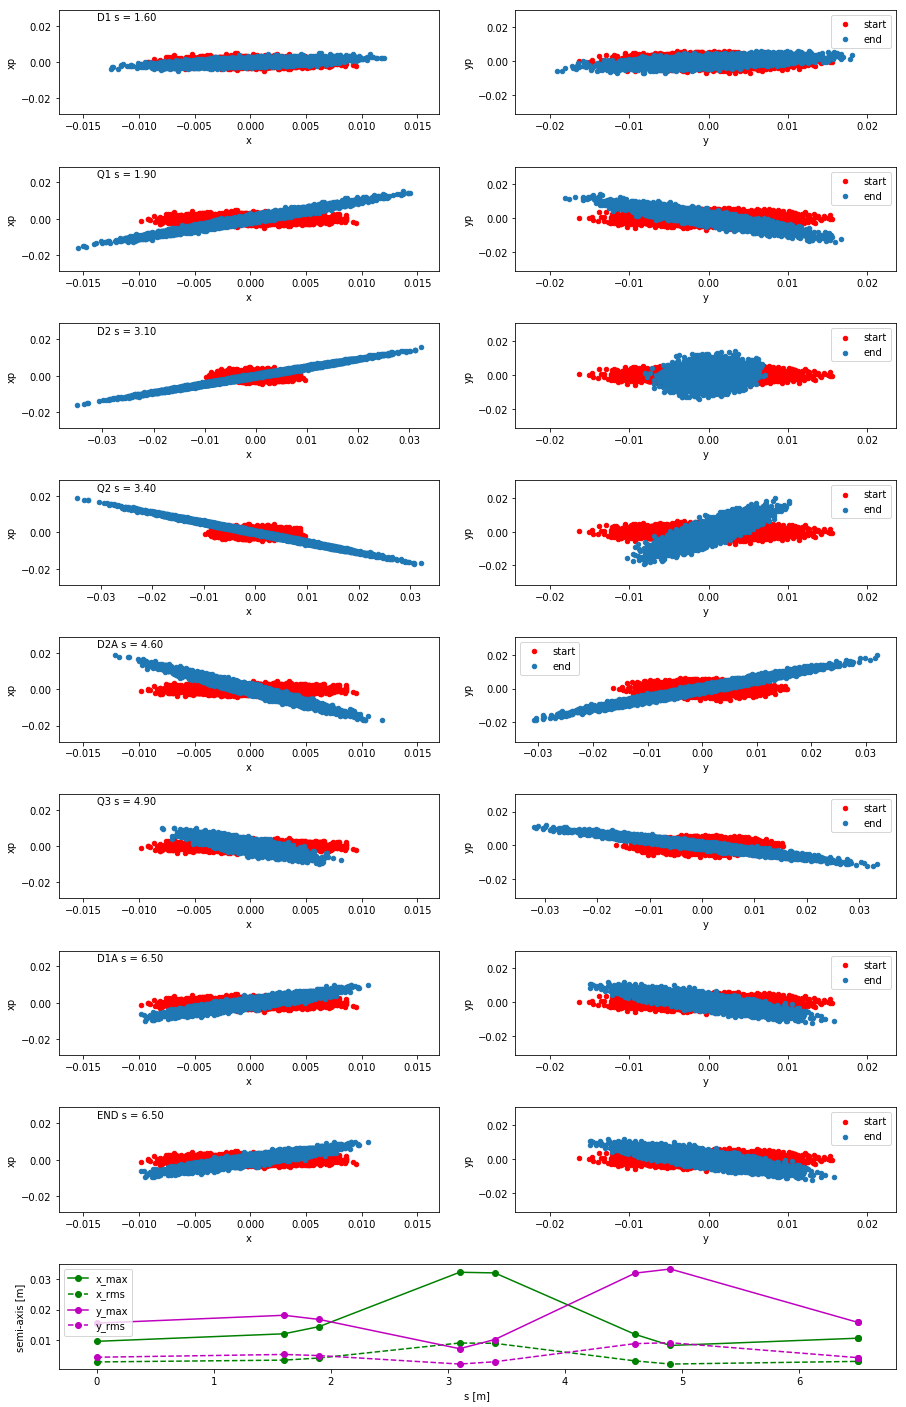

In [63]:
df = bmad.txt_to_df('../../Bmad/Playground/production/bin/','tracking_ele.txt')
bmad.plot_phase_space(df,figsize=(15,25))

#PATH_TO_DATA = '../../Multiplexer/Plots/'
#FILENAME = 'pure_tr-{}_{}_{}_sigmax{}'.format(l,d,L,2.7) #TODO: back to dynamic sigma_x
#plt.savefig(PATH_TO_DATA + FILENAME, format = 'png', dpi=900)

plt.show()

## kick-septum angle evaluation - symmetric 2 kicker setup

In [122]:
## beam parameters
Thet_init = 0

## distances
l_object = 0.1 # previous object to kicker (minimum)
l_kick = 0.5
l_sept = 0.75

lkq = d-l_kick-l_object
l_max = d + L + lkq # d: from q to q

## vertical distances
x_init = 0

# at septum
septum = 5e-3
x_sept = 4*sigma_x+septum
# at max prop
x_at_max_prop = 0.6
x_add = x_at_max_prop-x_sept

sept_type = 'OFS'

## iteration

start_kick = 0.001 # smallest kick-angle
step_kick = 0.001 # step size kick-angle

list_perm = np.linspace(0,1,1001) # range of septum anglesenvelope

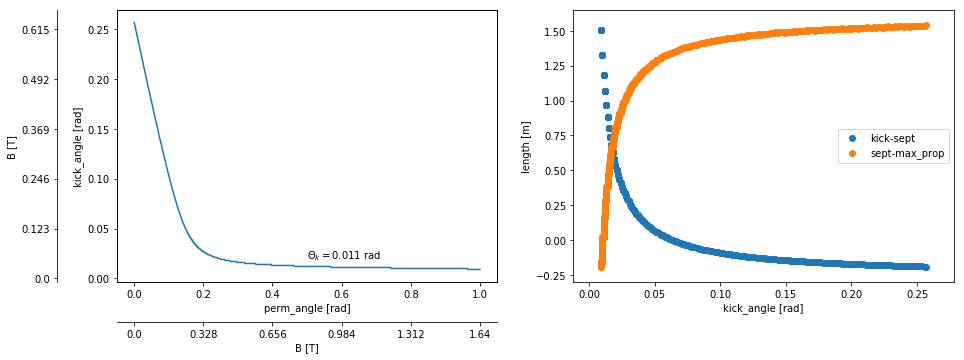

In [123]:
ax,data= geo.plot_comb_kick_sept(x_sept,
                                 x_add,
                                 x_init,
                                 Thet_init,
                                 l_kick,
                                 l_sept,
                                 sept_type,
                                 start_kick,
                                 step_kick,
                                 list_perm,
                                 l_max,
                                 brho=1.23,
                                 figsize = (15,5)
                                )


PATH_TO_DATA = '../../Multiplexer/Plots/'
FILENAME = 'ang_eval-{}_{}_{}_sx{}_ls{}_lk{}'.format(l_max,x_at_max_prop,sept_type,sigma_x,l_sept,l_kick)
plt.savefig(PATH_TO_DATA + FILENAME, format = 'png', dpi=900, bbox_inches="tight")

plt.show()

In [88]:
kick_d = data[0][0.5]

dks = [d[1] for d in data[1] if d[0] == kick_d]
dks_av = sum(dks)/len(dks)
# kicker-septum


dsf = [d[1] for d in data[2] if d[0] == kick_d]
dsf_av = sum(dsf)/len(dsf)
# septum - final

(kick_d,dks_av,dsf_av,l_max-l_sept)

(0.012, 1.066692267096755, 0.2199242992894485, 1.35)

## reduced kicker strength by quadrupole

In [89]:
kick_d*dks_av+l_kick*kick_d/2

0.015800307205161058

In [97]:
reduced = kick_d - 0.95e-3

if (dks_av-lkq-L)>=0:
    total_defl,new_angle = geo.quad_defl(k1,0.3,reduced,l_kick,lkq,dks_av-lkq-L)
    if total_defl >= (kick_d*dks_av+l_kick*kick_d/2):
        print('kicker-quad:', lkq)
        print('quad-septum:', dks_av-lkq-L)
        print(total_defl)
    print(new_angle-kick_d)
else:
    print('not working!:', dks_av-lkq-L)

kicker-quad: 0.6
quad-septum: 0.16669226709675494
0.015805929564845552
0.008251298282841043


In [107]:
geo.calc_magn(0.011,0.5,1.23)

0.027

## twiss QT study

In [111]:
eps_LINAC = np.pi # mm mrad
dia_LINAC = 10 # mm (6 sigma)

beta_init = (dia_LINAC/6)**2/eps_LINAC # m

beta = np.linspace(beta_init,10, 20) # m

sigma_X = np.sqrt(eps_LINAC*beta)
sigma_Xp = np.sqrt(eps_LINAC/beta)

In [112]:
Ms = bl.Mplot(elements,lengths)

In [113]:
max_rms = max(Ms[1][0])*sigma_X+max(Ms[1][1])*sigma_Xp

In [114]:
print(max(Ms[1][0]))
print(max(Ms[1][1]))

2.3529415162618394
5.533936028119204


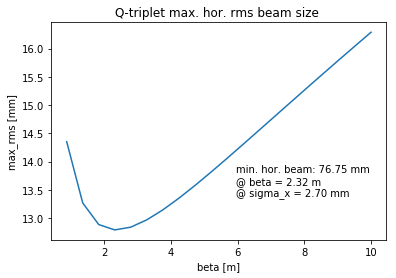

In [116]:
plt.plot(beta,max_rms)
plt.xlabel('beta [m]')
plt.ylabel('max_rms [mm]')
plt.text(0.55,0.2,
         '''min. hor. beam: {:.2f} mm 
@ beta = {:.2f} m 
@ sigma_x = {:.2f} mm'''.format(min(max_rms)*6,
                                beta[max_rms.argmin()],
                                sigma_X[max_rms.argmin()]),
         transform=plt.gca().transAxes)

plt.title('Q-triplet max. hor. rms beam size ')

PATH_TO_DATA = '../../Multiplexer/Plots/'
FILENAME = 'Twiss_Linac_QT_eval-{:.2f}'.format(eps_LINAC)
plt.savefig(PATH_TO_DATA + FILENAME, format = 'png', dpi=900)

plt.show()